# Momentum Strategy Backtest

**Classic 12-1 Momentum Strategy**

This notebook implements and backtests a momentum-based trading strategy:
- **Strategy**: Long top 20% momentum stocks, short/avoid bottom 20%
- **Signal**: 12-month return excluding last month (mom_12_1)
- **Rebalance**: Monthly
- **Universe**: S&P 500 stocks

**References:**
- Jegadeesh & Titman (1993): "Returns to Buying Winners and Selling Losers"
- Fama & French (2008): "Dissecting Anomalies"


In [1]:
# Setup: imports and configuration
import sys
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display

warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configure pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

# Resolve paths (works from repo root or notebooks/)
CWD = Path.cwd().resolve()
CANDIDATES_ROOT = [CWD, CWD.parent]

for root in CANDIDATES_ROOT:
    if (root / "config" / "settings.py").exists():
        if str(root) not in sys.path:
            sys.path.insert(0, str(root))
        break

def resolve_first_existing(paths: list[Path], fallback: Path) -> Path:
    for p in paths:
        if p.exists():
            return p
    return fallback

PARQUET_DIR = resolve_first_existing(
    [root / "data" / "factors" for root in CANDIDATES_ROOT],
    CWD / "data" / "factors",
)

print(f"📁 Data directory: {PARQUET_DIR}")
print(f"✅ Directory exists: {PARQUET_DIR.exists()}")


📁 Data directory: /Users/andres/Downloads/Cursor/quant/data/factors
✅ Directory exists: True


---
## 1. Load Data

Load price factors and market prices for backtesting.


In [2]:
# Load factors (long format) and prices (wide format)
factors_path = PARQUET_DIR / "factors_price.parquet"
prices_path = PARQUET_DIR / "prices.parquet"

if not factors_path.exists():
    raise FileNotFoundError(f"Factors file not found: {factors_path}")
if not prices_path.exists():
    raise FileNotFoundError(f"Prices file not found: {prices_path}")

print("Loading data...")
df_factors = pd.read_parquet(factors_path)
df_prices = pd.read_parquet(prices_path)

print(f"✅ Factors shape: {df_factors.shape}")
print(f"✅ Prices shape: {df_prices.shape}")
print(f"\nDate range: {df_factors.index.get_level_values('date').min()} to {df_factors.index.get_level_values('date').max()}")
print(f"Number of symbols: {df_factors.index.get_level_values('symbol').nunique()}")

# Preview
print("\nSample of factors data:")
display(df_factors.head(10))


Loading data...
✅ Factors shape: (12872160, 5)
✅ Prices shape: (25540, 504)

Date range: 1927-12-30 00:00:00-05:00 to 2025-11-20 00:00:00-05:00
Number of symbols: 504

Sample of factors data:


factor                            mom_12_1  mom_6_1  mom_3_1  vol_60d  \
date                      symbol                                        
1927-12-30 00:00:00-05:00 A            NaN      NaN      NaN      NaN   
                          AAPL         NaN      NaN      NaN      NaN   
                          ABBV         NaN      NaN      NaN      NaN   
                          ABNB         NaN      NaN      NaN      NaN   
                          ABT          NaN      NaN      NaN      NaN   
                          ACGL         NaN      NaN      NaN      NaN   
                          ACN          NaN      NaN      NaN      NaN   
                          ADBE         NaN      NaN      NaN      NaN   
                          ADI          NaN      NaN      NaN      NaN   
                          ADM          NaN      NaN      NaN      NaN   

factor                            beta_60d  
date                      symbol            
1927-12-30 00:00:00-05:00 A            NaN  
                          AAPL         NaN  
                          ABBV         NaN  
                          ABNB         NaN  
                          ABT          NaN  
                          ACGL         NaN  
                          ACN          NaN  
                          ADBE         NaN  
                          ADI          NaN  
                          ADM          NaN

---
## 2. Strategy Implementation

Implement the momentum strategy with proper portfolio construction.


In [3]:
def create_momentum_signals(
    df: pd.DataFrame,
    factor_col: str = 'mom_12_1',
    top_pct: float = 0.20,
    bottom_pct: float = 0.20,
    min_stocks: int = 20
) -> pd.DataFrame:
    """
    Create long/short signals based on momentum factor.
    
    Args:
        df: DataFrame with MultiIndex (date, symbol) and factor columns
        factor_col: Column to rank on
        top_pct: Percentage of stocks to go long
        bottom_pct: Percentage of stocks to short/avoid
        min_stocks: Minimum number of valid stocks required
    
    Returns:
        DataFrame with 'signal' column: 1 (long), -1 (short), 0 (neutral)
    """
    df = df.copy()
    df['signal'] = 0
    
    # Group by date and rank
    for date in df.index.get_level_values('date').unique():
        date_mask = df.index.get_level_values('date') == date
        date_data = df.loc[date_mask].copy()
        
        # Filter valid factor values
        valid_mask = (
            date_data[factor_col].notna() & 
            np.isfinite(date_data[factor_col]) &
            (date_data[factor_col].abs() < 10)  # Remove extreme outliers
        )
        valid_data = date_data[valid_mask]
        
        n_valid = len(valid_data)
        if n_valid < min_stocks:
            continue
        
        # Calculate percentile thresholds
        n_long = max(1, int(n_valid * top_pct))
        n_short = max(1, int(n_valid * bottom_pct))
        
        # Rank and assign signals
        ranks = valid_data[factor_col].rank(ascending=False)
        
        # Long: top momentum (use index to assign)
        long_idx = ranks[ranks <= n_long].index
        df.loc[long_idx, 'signal'] = 1
        
        # Short: bottom momentum (use index to assign)
        short_idx = ranks[ranks > (n_valid - n_short)].index
        df.loc[short_idx, 'signal'] = -1
    
    return df

print("Creating momentum signals...")
df_signals = create_momentum_signals(
    df_factors,
    factor_col='mom_12_1',
    top_pct=0.20,
    bottom_pct=0.20
)

# Summary statistics
signal_counts = df_signals.groupby(df_signals.index.get_level_values('date'))['signal'].value_counts().unstack(fill_value=0)
print(f"\nAverage portfolio composition:")
print(f"  Long positions: {signal_counts.get(1, pd.Series([0])).mean():.1f} stocks")
print(f"  Short positions: {signal_counts.get(-1, pd.Series([0])).mean():.1f} stocks")
print(f"  Neutral: {signal_counts.get(0, pd.Series([0])).mean():.1f} stocks")


Creating momentum signals...

Average portfolio composition:
  Long positions: 35.1 stocks
  Short positions: 35.1 stocks
  Neutral: 433.8 stocks


---
## 3. Backtest Engine

Calculate portfolio returns with transaction costs.


In [4]:
def calculate_portfolio_returns(
    signals: pd.DataFrame,
    prices: pd.DataFrame,
    rebalance_freq: str = 'M',
    transaction_cost: float = 0.001,
    long_only: bool = False
) -> pd.DataFrame:
    """
    Calculate portfolio returns based on signals.
    
    Args:
        signals: DataFrame with signal column
        prices: DataFrame with prices (wide format: date × symbols)
        rebalance_freq: Rebalancing frequency ('M' = monthly)
        transaction_cost: Cost per trade (10 bps = 0.001)
        long_only: If True, ignore short signals
    
    Returns:
        DataFrame with portfolio returns and metadata
    """
    # Calculate returns from prices
    returns = prices.pct_change()
    
    # Convert signals to wide format
    signals_wide = signals['signal'].unstack(fill_value=0)
    
    # Align dates
    common_dates = returns.index.intersection(signals_wide.index)
    returns = returns.loc[common_dates]
    signals_wide = signals_wide.loc[common_dates]
    
    # Resample to rebalance frequency
    rebalance_dates = returns.resample(rebalance_freq).last().index
    
    # Create positions DataFrame
    positions = pd.DataFrame(0.0, index=returns.index, columns=returns.columns)
    
    for i, rebal_date in enumerate(rebalance_dates):
        if rebal_date not in signals_wide.index:
            continue
        
        # Get signals for this rebalance date
        sigs = signals_wide.loc[rebal_date]
        
        if long_only:
            sigs = sigs.clip(lower=0)
        
        # Equal weight within longs and shorts
        n_long = (sigs > 0).sum()
        n_short = (sigs < 0).sum()
        
        weights = pd.Series(0.0, index=sigs.index)
        if n_long > 0:
            weights[sigs > 0] = 1.0 / n_long
        if n_short > 0 and not long_only:
            weights[sigs < 0] = -1.0 / n_short
        
        # Hold until next rebalance
        next_rebal = rebalance_dates[i+1] if i+1 < len(rebalance_dates) else returns.index[-1]
        hold_dates = returns.index[(returns.index >= rebal_date) & (returns.index < next_rebal)]
        
        for col in weights.index:
            if col in positions.columns:
                positions.loc[hold_dates, col] = weights[col]
    
    # Calculate daily portfolio returns
    portfolio_returns = (positions.shift(1) * returns).sum(axis=1)
    
    # Calculate turnover
    position_changes = positions.diff().abs().sum(axis=1)
    turnover = position_changes / 2
    
    # Apply transaction costs
    transaction_costs = turnover * transaction_cost
    net_returns = portfolio_returns - transaction_costs
    
    # Combine results
    results = pd.DataFrame({
        'gross_return': portfolio_returns,
        'transaction_cost': transaction_costs,
        'net_return': net_returns,
        'turnover': turnover,
        'n_long': (positions > 0).sum(axis=1),
        'n_short': (positions < 0).sum(axis=1)
    })
    
    return results

print("Running backtest...")
print("⚠️  This may take a minute...")

# Long/short strategy
backtest_results = calculate_portfolio_returns(
    signals=df_signals,
    prices=df_prices,
    rebalance_freq='M',
    transaction_cost=0.001,
    long_only=False
)

# Long-only for comparison
backtest_results_long = calculate_portfolio_returns(
    signals=df_signals,
    prices=df_prices,
    rebalance_freq='M',
    transaction_cost=0.001,
    long_only=True
)

# Benchmark (S&P 500)
if '^GSPC' in df_prices.columns:
    benchmark_returns = df_prices['^GSPC'].pct_change()
else:
    benchmark_returns = df_prices.pct_change().mean(axis=1)

benchmark_returns = benchmark_returns.reindex(backtest_results.index).fillna(0)

print("✅ Backtest complete!")
print(f"\nBacktest period: {backtest_results.index[0].date()} to {backtest_results.index[-1].date()}")
print(f"Number of trading days: {len(backtest_results)}")


Running backtest...
⚠️  This may take a minute...
✅ Backtest complete!

Backtest period: 1927-12-30 to 2025-11-20
Number of trading days: 25540


In [5]:
def calculate_performance_metrics(returns: pd.Series, benchmark: pd.Series = None, rf_rate: float = 0.02) -> dict:
    """Calculate comprehensive performance metrics."""
    returns_clean = returns.dropna()
    
    if len(returns_clean) == 0:
        return {}
    
    # Basic metrics
    total_return = (1 + returns_clean).prod() - 1
    n_years = len(returns_clean) / 252
    ann_return = (1 + total_return) ** (1 / n_years) - 1 if n_years > 0 else 0
    ann_vol = returns_clean.std() * np.sqrt(252)
    
    # Sharpe ratio
    excess_returns = returns_clean - rf_rate / 252
    sharpe = (excess_returns.mean() * 252) / (returns_clean.std() * np.sqrt(252)) if returns_clean.std() > 0 else 0
    
    # Sortino ratio
    downside_returns = returns_clean[returns_clean < 0]
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino = (ann_return - rf_rate) / downside_vol if downside_vol > 0 else 0
    
    # Drawdown
    cumulative = (1 + returns_clean).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calmar ratio
    calmar = ann_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Win rate
    win_rate = (returns_clean > 0).sum() / len(returns_clean)
    
    metrics = {
        'Total Return': total_return,
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown,
        'Calmar Ratio': calmar,
        'Win Rate': win_rate,
        'Best Day': returns_clean.max(),
        'Worst Day': returns_clean.min(),
    }
    
    # Information ratio (vs benchmark)
    if benchmark is not None:
        benchmark_clean = benchmark.reindex(returns_clean.index).fillna(0)
        excess_ret = returns_clean - benchmark_clean
        tracking_error = excess_ret.std() * np.sqrt(252)
        information_ratio = (excess_ret.mean() * 252) / tracking_error if tracking_error > 0 else 0
        metrics['Information Ratio'] = information_ratio
        metrics['Tracking Error'] = tracking_error
    
    return metrics

# Calculate metrics
print("="*80)
print("PERFORMANCE SUMMARY")
print("="*80)

metrics_ls = calculate_performance_metrics(backtest_results['net_return'], benchmark_returns)
metrics_long = calculate_performance_metrics(backtest_results_long['net_return'], benchmark_returns)
metrics_bench = calculate_performance_metrics(benchmark_returns)

# Create comparison table
comparison = pd.DataFrame({
    'Long/Short': metrics_ls,
    'Long Only': metrics_long,
    'Benchmark': metrics_bench
}).T

display(comparison.style.format({
    'Total Return': '{:.2%}',
    'Annual Return': '{:.2%}',
    'Annual Volatility': '{:.2%}',
    'Sharpe Ratio': '{:.2f}',
    'Sortino Ratio': '{:.2f}',
    'Max Drawdown': '{:.2%}',
    'Calmar Ratio': '{:.2f}',
    'Win Rate': '{:.2%}',
    'Best Day': '{:.2%}',
    'Worst Day': '{:.2%}',
    'Information Ratio': '{:.2f}',
    'Tracking Error': '{:.2%}',
}))


PERFORMANCE SUMMARY


,Total Return,Annual Return,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Calmar Ratio,Win Rate,Best Day,Worst Day,Information Ratio,Tracking Error
Long/Short,916.75%,2.31%,10.80%,0.08,0.03,-68.33%,0.03,24.10%,8.28%,-9.96%,-0.22,21.47%
Long Only,2622669.82%,10.56%,13.10%,0.68,0.59,-43.62%,0.24,25.23%,10.77%,-18.12%,0.20,16.57%
Benchmark,36925.82%,6.01%,18.59%,0.30,0.27,-86.19%,0.07,50.49%,16.61%,-20.47%,nan,nan%


---
## 5. Visualizations

Create comprehensive performance visualizations.


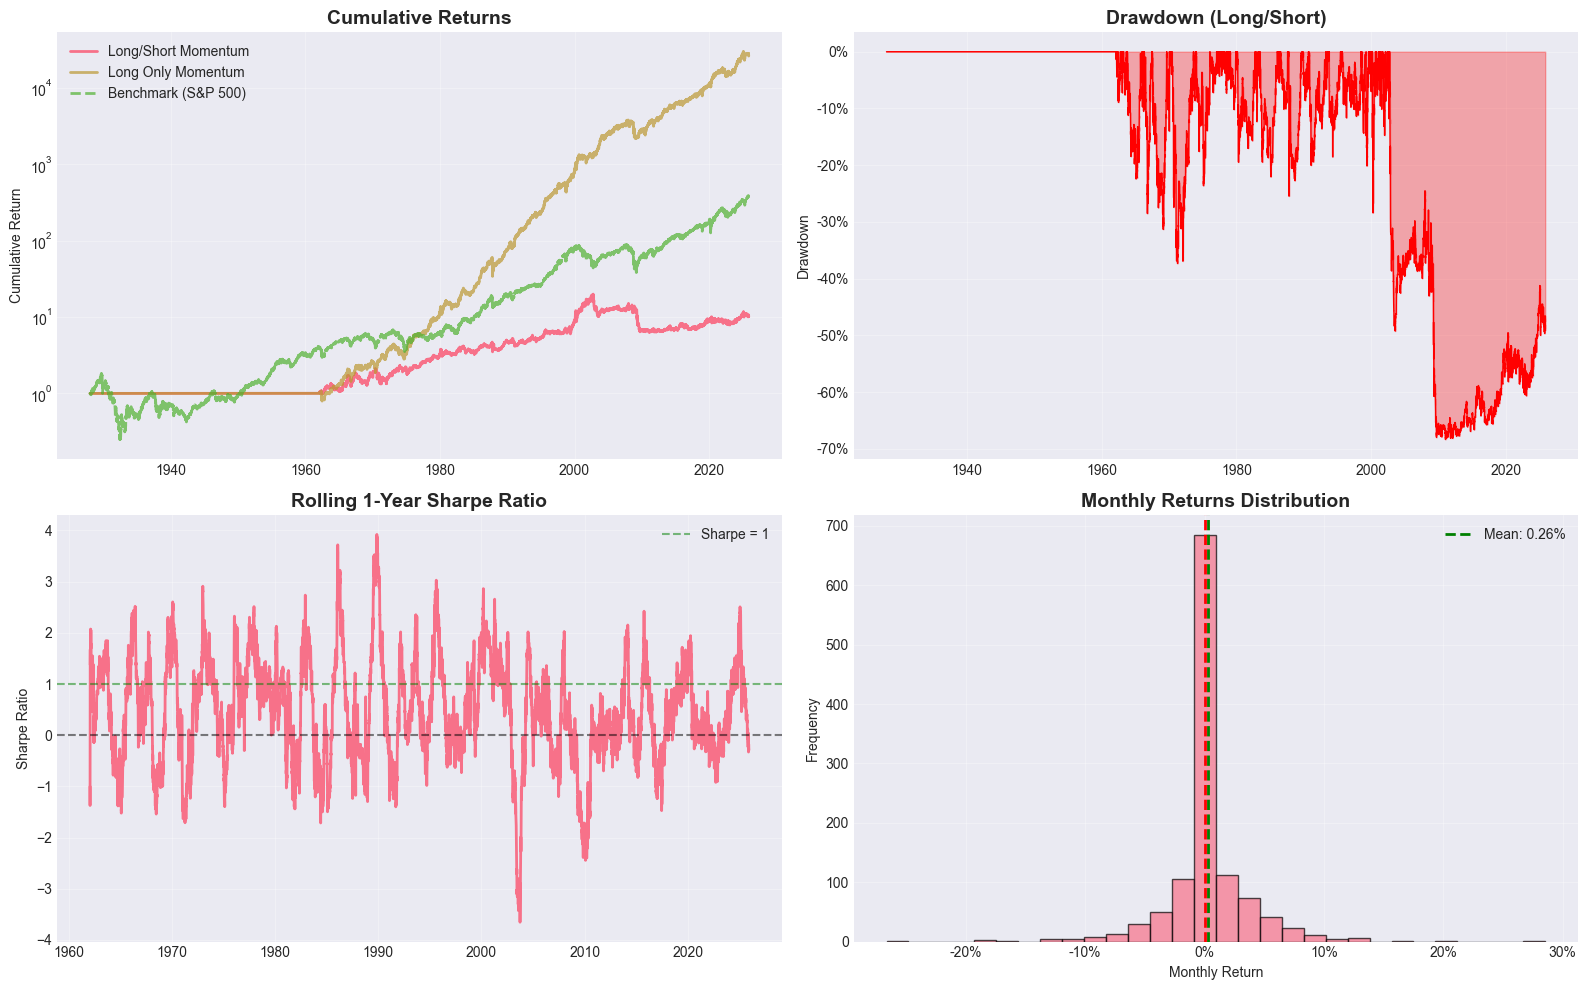


Monthly return statistics:
  Mean: 0.26%
  Median: 0.00%
  Std: 3.47%
  Positive months: 392 / 1176 (33.3%)


In [6]:
# Calculate cumulative returns
cum_ret_ls = (1 + backtest_results['net_return']).cumprod()
cum_ret_long = (1 + backtest_results_long['net_return']).cumprod()
cum_ret_bench = (1 + benchmark_returns).cumprod()

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Cumulative returns
ax = axes[0, 0]
ax.plot(cum_ret_ls.index, cum_ret_ls.values, label='Long/Short Momentum', linewidth=2)
ax.plot(cum_ret_long.index, cum_ret_long.values, label='Long Only Momentum', linewidth=2, alpha=0.7)
ax.plot(cum_ret_bench.index, cum_ret_bench.values, label='Benchmark (S&P 500)', linewidth=2, alpha=0.7, linestyle='--')
ax.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
ax.set_ylabel('Cumulative Return')
ax.legend(loc='best')
ax.grid(True, alpha=0.3)
ax.set_yscale('log')

# Plot 2: Drawdown
ax = axes[0, 1]
running_max = cum_ret_ls.expanding().max()
drawdown = (cum_ret_ls - running_max) / running_max
ax.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
ax.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax.set_title('Drawdown (Long/Short)', fontsize=14, fontweight='bold')
ax.set_ylabel('Drawdown')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.grid(True, alpha=0.3)

# Plot 3: Rolling Sharpe Ratio
ax = axes[1, 0]
rolling_sharpe = (
    backtest_results['net_return'].rolling(252).mean() * 252 / 
    (backtest_results['net_return'].rolling(252).std() * np.sqrt(252))
)
ax.plot(rolling_sharpe.index, rolling_sharpe.values, linewidth=2)
ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
ax.set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
ax.set_ylabel('Sharpe Ratio')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Monthly returns distribution
ax = axes[1, 1]
monthly_returns = backtest_results['net_return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
ax.hist(monthly_returns.values, bins=30, alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.axvline(x=monthly_returns.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {monthly_returns.mean():.2%}')
ax.set_title('Monthly Returns Distribution', fontsize=14, fontweight='bold')
ax.set_xlabel('Monthly Return')
ax.set_ylabel('Frequency')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMonthly return statistics:")
print(f"  Mean: {monthly_returns.mean():.2%}")
print(f"  Median: {monthly_returns.median():.2%}")
print(f"  Std: {monthly_returns.std():.2%}")
print(f"  Positive months: {(monthly_returns > 0).sum()} / {len(monthly_returns)} ({(monthly_returns > 0).mean():.1%})")


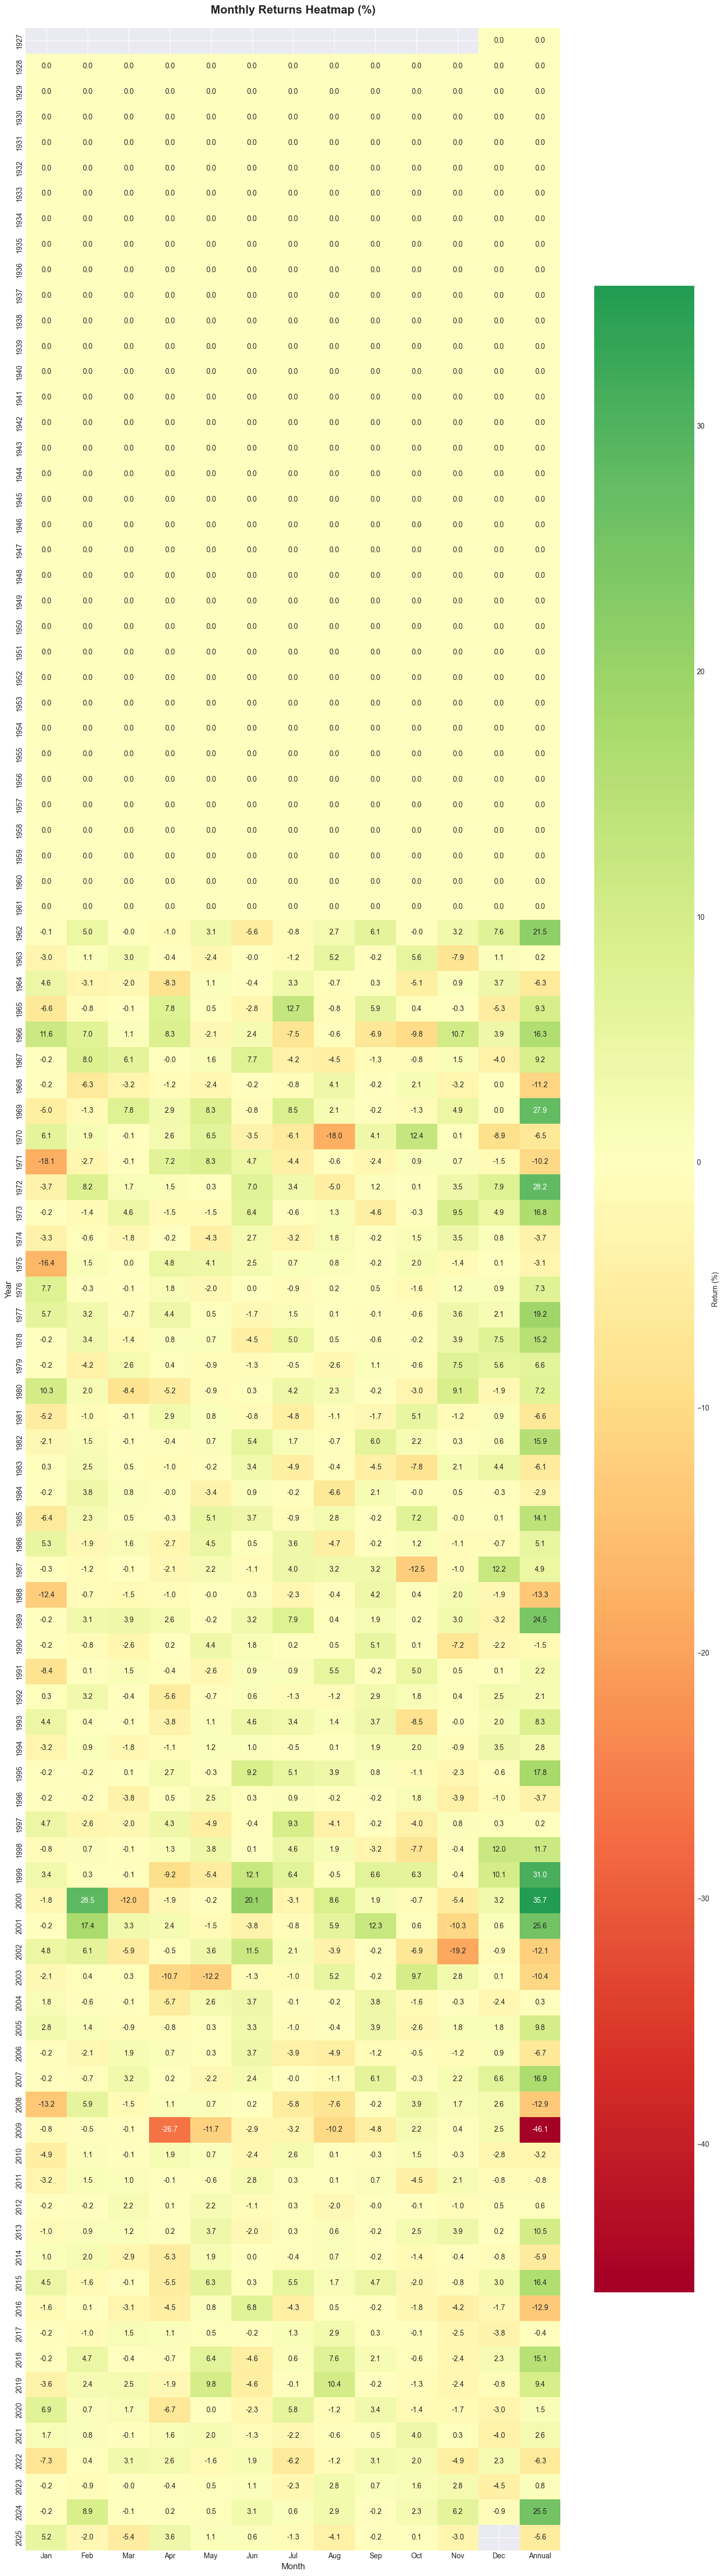

In [7]:
# Returns Heatmap by Year and Month
monthly_rets = backtest_results['net_return'].resample('M').apply(lambda x: (1 + x).prod() - 1)
monthly_rets.index = pd.to_datetime(monthly_rets.index)

# Pivot to year × month
returns_pivot = pd.DataFrame({
    'Year': monthly_rets.index.year,
    'Month': monthly_rets.index.month,
    'Return': monthly_rets.values
}).pivot(index='Year', columns='Month', values='Return')

# Add annual returns
annual_rets = backtest_results['net_return'].resample('Y').apply(lambda x: (1 + x).prod() - 1)
returns_pivot['Annual'] = annual_rets.values

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, max(8, len(returns_pivot) * 0.5)))
sns.heatmap(
    returns_pivot * 100,
    annot=True,
    fmt='.1f',
    cmap='RdYlGn',
    center=0,
    cbar_kws={'label': 'Return (%)'},
    ax=ax
)
ax.set_title('Monthly Returns Heatmap (%)', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Annual'])
plt.tight_layout()
plt.show()


---
## 6. Statistical Significance

Test if momentum returns are statistically significant.


In [8]:
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

# T-test: Are mean returns significantly different from zero?
returns_clean = backtest_results['net_return'].dropna()
t_stat, p_value = stats.ttest_1samp(returns_clean, 0)

print(f"\n1. T-test (Mean Return vs Zero):")
print(f"   Mean daily return: {returns_clean.mean():.4%}")
print(f"   Annualized: {returns_clean.mean() * 252:.2%}")
print(f"   T-statistic: {t_stat:.4f}")
print(f"   P-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"   ✅ Result: Statistically significant at 5% level")
else:
    print(f"   ⚠️  Result: Not statistically significant at 5% level")

# Test vs benchmark
excess_returns = returns_clean - benchmark_returns.reindex(returns_clean.index).fillna(0)
t_stat_excess, p_value_excess = stats.ttest_1samp(excess_returns.dropna(), 0)

print(f"\n2. T-test (Excess Return vs Benchmark):")
print(f"   Mean daily excess return: {excess_returns.mean():.4%}")
print(f"   Annualized: {excess_returns.mean() * 252:.2%}")
print(f"   T-statistic: {t_stat_excess:.4f}")
print(f"   P-value: {p_value_excess:.4f}")
if p_value_excess < 0.05:
    print(f"   ✅ Result: Significantly outperforms benchmark at 5% level")
else:
    print(f"   ⚠️  Result: Does not significantly outperform benchmark at 5% level")

# Normality test (Jarque-Bera)
jb_stat, jb_pvalue = stats.jarque_bera(returns_clean)
print(f"\n3. Jarque-Bera Test (Normality):")
print(f"   JB statistic: {jb_stat:.4f}")
print(f"   P-value: {jb_pvalue:.4f}")
if jb_pvalue < 0.05:
    print(f"   ⚠️  Result: Returns are NOT normally distributed (has fat tails/skew)")
else:
    print(f"   ✅ Result: Returns appear normally distributed")

# Distribution shape
skew = stats.skew(returns_clean)
kurt = stats.kurtosis(returns_clean)
print(f"\n4. Distribution Shape:")
print(f"   Skewness: {skew:.4f} {'(negative/left tail)' if skew < 0 else '(positive/right tail)'}")
print(f"   Excess Kurtosis: {kurt:.4f} {'(fat tails)' if kurt > 0 else '(thin tails)'}")


STATISTICAL SIGNIFICANCE TESTS

1. T-test (Mean Return vs Zero):
   Mean daily return: 0.0114%
   Annualized: 2.87%
   T-statistic: 2.6780
   P-value: 0.0074
   ✅ Result: Statistically significant at 5% level

2. T-test (Excess Return vs Benchmark):
   Mean daily excess return: -0.0186%
   Annualized: -4.69%
   T-statistic: -2.2007
   P-value: 0.0278
   ✅ Result: Significantly outperforms benchmark at 5% level

3. Jarque-Bera Test (Normality):
   JB statistic: 326034.2854
   P-value: 0.0000
   ⚠️  Result: Returns are NOT normally distributed (has fat tails/skew)

4. Distribution Shape:
   Skewness: -0.6750 (negative/left tail)
   Excess Kurtosis: 17.4514 (fat tails)


---
## 7. Summary & Next Steps

Key takeaways and ideas for improvement.


In [9]:
print("="*80)
print("SUMMARY & INSIGHTS")
print("="*80)

print(f"\n📊 Strategy Overview:")
print(f"   • Long top 20% momentum stocks")
print(f"   • Short bottom 20% momentum stocks")
print(f"   • Monthly rebalancing")
print(f"   • 10 bps transaction costs")

print(f"\n💰 Performance Highlights:")
print(f"   • Total Return: {metrics_ls['Total Return']:.2%}")
print(f"   • Annual Return: {metrics_ls['Annual Return']:.2%}")
print(f"   • Sharpe Ratio: {metrics_ls['Sharpe Ratio']:.2f}")
print(f"   • Max Drawdown: {metrics_ls['Max Drawdown']:.2%}")

print(f"\n🎯 Next Steps to Improve Strategy:")
print(f"\n1. Risk Management:")
print(f"   • Add volatility targeting (scale positions by vol)")
print(f"   • Implement sector neutrality (avoid sector bets)")
print(f"   • Add stop-losses or dynamic position sizing")

print(f"\n2. Signal Enhancement:")
print(f"   • Combine multiple momentum timeframes (3m, 6m, 12m)")
print(f"   • Filter by other factors (e.g., only low-vol stocks)")
print(f"   • Use machine learning to weight signals")

print(f"\n3. Regime Detection:")
print(f"   • Apply momentum only in bull markets")
print(f"   • Use macro indicators (we have macro_z.parquet!)")
print(f"   • Switch to defensive factors in bear markets")

print(f"\n4. Transaction Cost Optimization:")
print(f"   • Reduce turnover with buffer zones (e.g., 15-25% bands)")
print(f"   • Quarterly instead of monthly rebalancing")
print(f"   • Only trade when signal strength is high")

print(f"\n5. Additional Analysis:")
print(f"   • Out-of-sample testing (train/test split)")
print(f"   • Monte Carlo simulations")
print(f"   • Compare to Fama-French factors")
print(f"   • Analyze performance by market regime")

print("\n" + "="*80)
print("🎉 Congratulations! You've built your first quant strategy!")
print("="*80)


SUMMARY & INSIGHTS

📊 Strategy Overview:
   • Long top 20% momentum stocks
   • Short bottom 20% momentum stocks
   • Monthly rebalancing
   • 10 bps transaction costs

💰 Performance Highlights:
   • Total Return: 916.75%
   • Annual Return: 2.31%
   • Sharpe Ratio: 0.08
   • Max Drawdown: -68.33%

🎯 Next Steps to Improve Strategy:

1. Risk Management:
   • Add volatility targeting (scale positions by vol)
   • Implement sector neutrality (avoid sector bets)
   • Add stop-losses or dynamic position sizing

2. Signal Enhancement:
   • Combine multiple momentum timeframes (3m, 6m, 12m)
   • Filter by other factors (e.g., only low-vol stocks)
   • Use machine learning to weight signals

3. Regime Detection:
   • Apply momentum only in bull markets
   • Use macro indicators (we have macro_z.parquet!)
   • Switch to defensive factors in bear markets

4. Transaction Cost Optimization:
   • Reduce turnover with buffer zones (e.g., 15-25% bands)
   • Quarterly instead of monthly rebalancing
  